# Evaluating models on datasets

## Models trained with augmentation

In [2]:
from pathlib import Path

import evaluate
import pandas as pd
import transformers
from evaluate import evaluator
from omegaconf import OmegaConf
from repsim.nlp import get_dataset

model_dir = Path("/root/similaritybench/experiments/models/nlp/augmentation")
dataset_dir = Path("/root/similaritybench/experiments/datasets/nlp/robustness")


model_pattern = "sst2*"
dataset_pattern = "sst2*strength*"
split = "validation"
feature_column = "augmented"

metric = evaluate.load("accuracy")
task_evaluator = evaluator("text-classification")

columns = ["model", "dataset", "acc"]
records = []
for model_path in model_dir.glob(model_pattern):
    tokenizer_path = OmegaConf.load(model_path / "config.yaml").model.kwargs.tokenizer_name
    pipe = transformers.pipeline(
        "text-classification",
        model=str(model_path),
        tokenizer=tokenizer_path,
        device=0,
        max_length=128,
    )

    for ds_path in dataset_dir.glob(dataset_pattern):
        ds = get_dataset(str(ds_path))

        results = task_evaluator.compute(
            model_or_pipeline=pipe,
            data=ds[split],
            metric=metric,
            label_mapping={"LABEL_0": 0, "LABEL_1": 1},
            input_column=feature_column,
        )

        records.append((model_path.name, ds_path.name, results["accuracy"]))
df = pd.DataFrame.from_records(records, columns=columns)

df.to_csv("augmented_evals.csv")


## Clean models

In [16]:
from pathlib import Path

import evaluate
import pandas as pd
import transformers
from evaluate import evaluator
from omegaconf import OmegaConf
from repsim.nlp import get_dataset

model_dir = Path("/root/similaritybench/experiments/models/nlp/standard")
dataset_dir = Path("/root/similaritybench/experiments/datasets/nlp/robustness")


model_pattern = "sst2*"
dataset_pattern = "sst2*strength*"
split = "validation"
feature_column = "augmented"

metric = evaluate.load("accuracy")
task_evaluator = evaluator("text-classification")

columns = ["model", "dataset", "acc"]
records = []
for model_path in model_dir.glob(model_pattern):
    tokenizer_path = "google/multiberts-seed_0"
    pipe = transformers.pipeline(
        "text-classification",
        model=str(model_path),
        tokenizer=tokenizer_path,
        device=0,
        max_length=128,
    )

    for ds_path in dataset_dir.glob(dataset_pattern):
        ds = get_dataset(str(ds_path))

        results = task_evaluator.compute(
            model_or_pipeline=pipe,
            data=ds[split],
            metric=metric,
            label_mapping={"LABEL_0": 0, "LABEL_1": 1},
            input_column=feature_column,
        )

        records.append((model_path.name, ds_path.name, results["accuracy"]))
clean_df = pd.DataFrame.from_records(records, columns=columns)

In [17]:
clean_df.to_csv("clean_evals.csv")

## Analysis. Are models with different training setup distinguishable from their performance?

In [18]:
def strength(s: str):
    str_to_float = {"025": 0.25, "05": 0.5, "075": 0.75,"10": 1.0,}
    s = s.split("_")[-1].replace("strength", "")
    return str_to_float[s]

def seed(s: str):
    s = s.split("_")[1].replace("pretrain", "")
    return int(s)


clean_df["split"] = split
clean_df["train_aug_strength"] = clean_df["model"].map(lambda x: 0.0)
clean_df["dataset_aug_strength"] = clean_df["dataset"].map(strength)
clean_df["seed"] = clean_df["model"].map(seed)
clean_df


,model,dataset,acc,split,train_aug_strength,dataset_aug_strength,seed
0,sst2_pretrain2_finetune2,sst2_eda_strength075,0.786697,validation,0.0,0.75,2
1,sst2_pretrain2_finetune2,sst2_eda_strength10,0.752294,validation,0.0,1.00,2
2,sst2_pretrain2_finetune2,sst2_eda_strength05,0.813073,validation,0.0,0.50,2
3,sst2_pretrain2_finetune2,sst2_eda_strength025,0.878440,validation,0.0,0.25,2
4,sst2_pretrain1_finetune1,sst2_eda_strength075,0.785550,validation,0.0,0.75,1
5,sst2_pretrain1_finetune1,sst2_eda_strength10,0.744266,validation,0.0,1.00,1
6,sst2_pretrain1_finetune1,sst2_eda_strength05,0.838303,validation,0.0,0.50,1
7,sst2_pretrain1_finetune1,sst2_eda_strength025,0.864679,validation,0.0,0.25,1
8,sst2_pretrain0_finetune0,sst2_eda_strength075,0.777523,validation,0.0,0.75,0
9,sst2_pretrain0_finetune0,sst2_eda_strength10,0.745413,validation,0.0,1.00,0


In [9]:
def strength(s: str):
    str_to_float = {"025": 0.25, "05": 0.5, "075": 0.75,"10": 1.0,}
    s = s.split("_")[-1].replace("strength", "")
    return str_to_float[s]

def seed(s: str):
    s = s.split("_")[1].replace("pre", "")
    return int(s)


df["split"] = split
df["train_aug_strength"] = df["model"].map(strength)
df["dataset_aug_strength"] = df["dataset"].map(strength)
df["seed"] = df["model"].map(seed)
df


,model,dataset,acc,split,train_aug_strength,seed,dataset_aug_strength
0,sst2_pre7_ft7_eda_strength075,sst2_eda_strength075,0.815367,validation,0.75,7,0.75
1,sst2_pre7_ft7_eda_strength075,sst2_eda_strength10,0.767202,validation,0.75,7,1.00
2,sst2_pre7_ft7_eda_strength075,sst2_eda_strength05,0.837156,validation,0.75,7,0.50
3,sst2_pre7_ft7_eda_strength075,sst2_eda_strength025,0.857798,validation,0.75,7,0.25
4,sst2_pre1_ft1_eda_strength05,sst2_eda_strength075,0.791284,validation,0.50,1,0.75
...,...,...,...,...,...,...,...
155,sst2_pre8_ft8_eda_strength025,sst2_eda_strength025,0.876147,validation,0.25,8,0.25
156,sst2_pre3_ft3_eda_strength025,sst2_eda_strength075,0.799312,validation,0.25,3,0.75
157,sst2_pre3_ft3_eda_strength025,sst2_eda_strength10,0.759174,validation,0.25,3,1.00
158,sst2_pre3_ft3_eda_strength025,sst2_eda_strength05,0.839450,validation,0.25,3,0.50


In [19]:
df = pd.concat((df, clean_df))

In [10]:
df.groupby(["train_aug_strength", "dataset_aug_strength"])["acc"].agg("mean")

train_aug_strength  dataset_aug_strength
0.25                0.25                    0.870986
                    0.50                    0.834289
                    0.75                    0.799885
                    1.00                    0.758945
0.50                0.25                    0.863532
                    0.50                    0.835206
                    0.75                    0.798624
                    1.00                    0.756537
0.75                0.25                    0.864679
                    0.50                    0.838303
                    0.75                    0.803211
                    1.00                    0.768578
1.00                0.25                    0.859289
                    0.50                    0.833945
                    0.75                    0.798394
                    1.00                    0.771216
Name: acc, dtype: float64

<Axes: xlabel='dataset_aug_strength', ylabel='acc'>

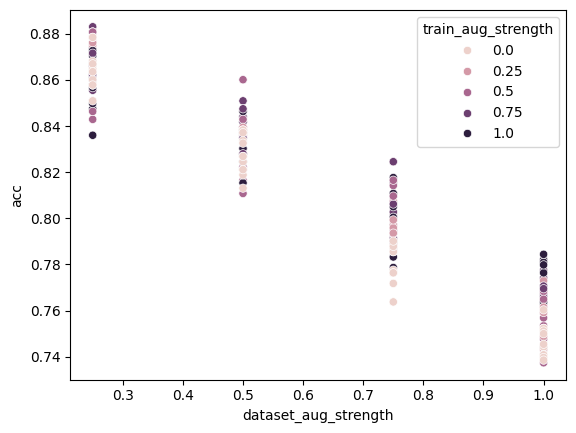

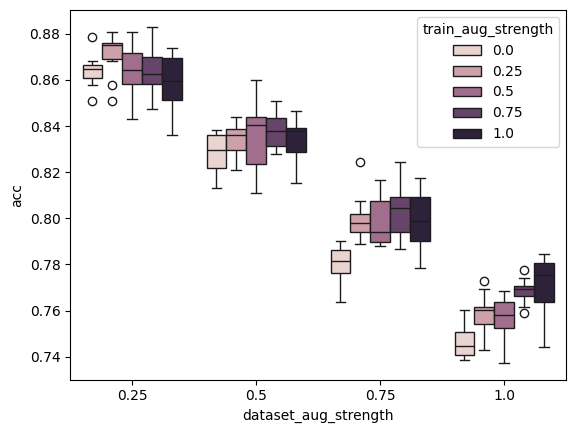

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure()
sns.scatterplot(data=df, hue="train_aug_strength", y="acc", x="dataset_aug_strength")

plt.figure()
sns.boxplot(data=df, hue="train_aug_strength", y="acc", x="dataset_aug_strength")

Statistically significant difference in avg acc?

In [37]:
import scipy.stats
import itertools

cols = ["aug1", "aug2", "ds_aug", "pval"]
records = []
for aug1, aug2 in itertools.combinations(df["train_aug_strength"].unique(), r=2):
    for ds_strength in df["dataset_aug_strength"].unique():
        x = df.loc[(df["train_aug_strength"] == aug1) & (df["dataset_aug_strength"] == ds_strength), "acc"]
        y = df.loc[(df["train_aug_strength"] == aug2) & (df["dataset_aug_strength"] == ds_strength), "acc"]
        # plt.figure()
        # sns.histplot(x)
        # sns.histplot(y)
        records.append((aug1, aug2, ds_strength, scipy.stats.ttest_ind(x, y, permutations=10000).pvalue))

pvals = pd.DataFrame.from_records(records, columns=cols)
pvals.head()

,aug1,aug2,ds_aug,pval
0,0.75,0.5,0.75,0.382762
1,0.75,0.5,1.00,0.001900
2,0.75,0.5,0.50,0.585241
3,0.75,0.5,0.25,0.819318
4,0.75,1.0,0.75,0.387561


In [39]:
significant = pvals[pvals.pval < 0.05]
print(len(significant)/len(pvals))

significant

0.35


,aug1,aug2,ds_aug,pval
1,0.75,0.50,1.00,0.001900
9,0.75,0.25,1.00,0.009099
12,0.75,0.00,0.75,0.000100
13,0.75,0.00,1.00,0.000100
14,0.75,0.00,0.50,0.017698
17,0.50,1.00,1.00,0.007599
24,0.50,0.00,0.75,0.000200
25,0.50,0.00,1.00,0.014999
29,1.00,0.25,1.00,0.021498
31,1.00,0.25,0.25,0.032297
